In [68]:
from BufferGeometry import BufferGeometry
from utils.analysis import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from scipy import linalg as la

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
text = "The sky is the"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs.input_ids

# Forward pass with hidden states
with torch.no_grad():
    outputs = model(input_ids, output_hidden_states=True, return_dict=True)

hidden_states = outputs.hidden_states  # Tuple: [embedding] + [each layer output]

In [69]:
#extract buffer states
buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])
buffer_states.shape

(13, 4, 768)

In [71]:
#loop for analysis

volumes = []
gd = []
cos_sim = []
mean_vector = []

#reduce dimension of initial buffer
buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis = 0, keepdims=True)
U, S, Vt = la.svd(buffer_scaled_0)
eigenvalues = S**2
explained_variance_ratio = eigenvalues/np.sum(eigenvalues)
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)

U_reduced = U[:,:n_components]
S_reduced = np.diag(S[:n_components])
Vt_reduced = Vt[:n_components,:]

buffer_reduced_0 = np.dot(np.dot(U_reduced,S_reduced),Vt_reduced)


for i in range(buffer_states.shape[0]):
    bg = BufferGeometry(buffer_states[i,:,:])
    
    #volume
    volumes.append(bg.volume())
    print(bg.volume())
    #cosine similarity with last vector of the buffer
    cos_sim.append(bg.cosine_similarity(buffer_states[-1,:,:]))
    #mean vectors
    mean_vector.append(bg.mean_vector())

    #dimensionality reduction for Grassmann distance
    #SVD
    
    buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis = 0, keepdims=True)
    U, S, Vt = la.svd(buffer_scaled)
    eigenvalues = S**2
    explained_variance_ratio = eigenvalues/np.sum(eigenvalues)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)

    U_reduced = U[:,:n_components]
    S_reduced = np.diag(S[:n_components])
    Vt_reduced = Vt[:n_components,:]

    buffer_reduced = np.dot(np.dot(U_reduced,S_reduced),Vt_reduced)

    #compute grassman distance
    bg_reduced = BufferGeometry(buffer_reduced)
    gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))
    
    #update buffer0
    buffer_reduced_0 = buffer_reduced



494.3714
6716122.5
42261376.0
202210190.0
277032830.0
411016260.0
606750140.0
938552500.0
1585395800.0
2583798300.0
4725074000.0
10471854000.0
4699410.5


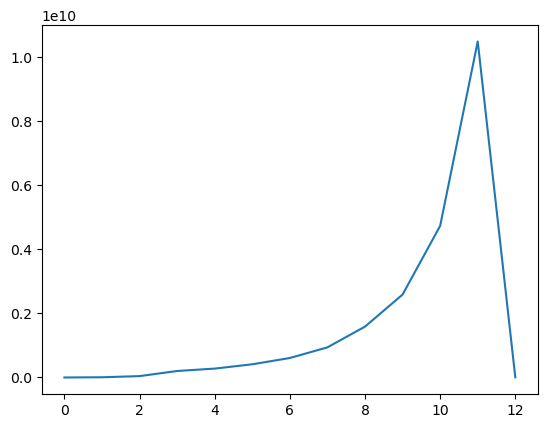

In [72]:
plt.plot(range(len(volumes)),volumes)
#plt.yscale("log")

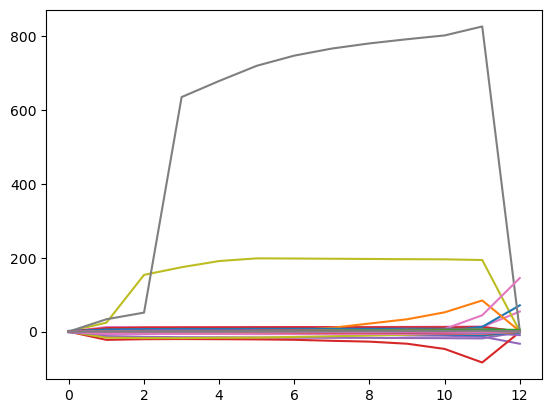

In [73]:
plt.plot(range(len(mean_vector)),mean_vector)

ValueError: x and y can be no greater than 2D, but have shapes (13,) and (13, 1, 1)

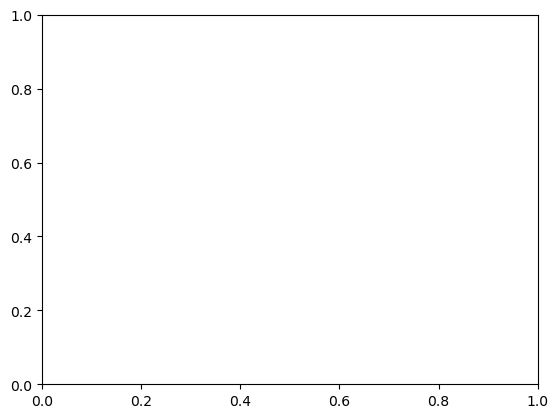

In [74]:
plt.plot(range(len(cos_sim)),cos_sim)

[2.7206974, 2.7206948, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927, 3.1415927]


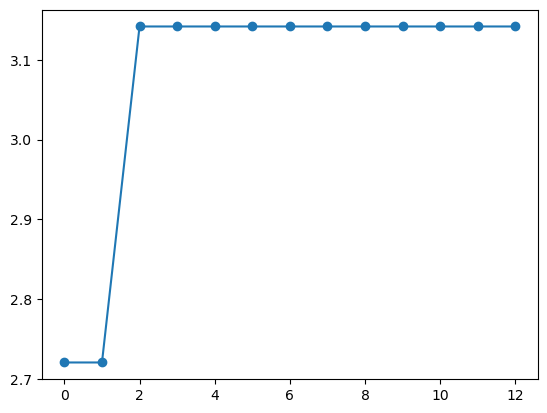

In [81]:
plt.plot(range(len(gd)),gd,marker = 'o')
print(gd)